In [2]:
import torch as th
import torch
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr
import torch.nn.functional as F
import networkx as nx
from math import sin, pi, cos
from matplotlib.path import Path
import matplotlib.pyplot as plt

In [3]:
def dist_perfectV(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param normals: List of [nx, ny] normal vectors for each sample
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size
    centers = np.array([c for c, _ in samples_with_widths], dtype=np.float32)
    widths = np.array([w for _, w in samples_with_widths], dtype=np.float32)
    normals = np.array(normals, dtype=np.float32)

    if len(centers) == 0:
        dist_map_t = torch.zeros((w, h), dtype=torch.float32)
        return dist_map_t.cuda() if iscuda else dist_map_t

    left_pts = centers - (normals * widths[:, None] / 2)
    right_pts = centers + (normals * widths[:, None] / 2)

    end_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_end = centers[-1]
        r_end = widths[-1] / 2
        P_end = left_pts[-1]

        dx = P_end[0] - C_end[0]
        dy = P_end[1] - C_end[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_end[0] + r_end * np.cos(theta)
        y = C_end[1] + r_end * np.sin(theta)
        end_cap_points = np.column_stack((x, y))[1:-1]

    start_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_start = centers[0]
        r_start = widths[0] / 2
        P_start = right_pts[0]

        dx = P_start[0] - C_start[0]
        dy = P_start[1] - C_start[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_start[0] + r_start * np.cos(theta)
        y = C_start[1] + r_start * np.sin(theta)
        start_cap_points = np.column_stack((x, y))[1:]

    reversed_right_pts = right_pts[::-1]
    if len(reversed_right_pts) > 0:
        reversed_right_pts = reversed_right_pts[1:]

    polygon = np.vstack([
        left_pts,
        end_cap_points,
        reversed_right_pts,
        start_cap_points
    ])

    path = Path(polygon)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    print(grid_points)
    is_inside = path.contains_points(grid_points).reshape(h, w).T

    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]
        seg_dist = qq(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    dist_map = np.where(is_inside, -dist_map, dist_map)

    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def qq(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    # treat seg_p1 as the origin, then calculate 
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)


#######################
# DIST MAP 3D

def compute_3d_distance_map(centers, widths, tangents, grid_shape, voxel_size, origin, device='cuda'):
    """
    Compute a 3D signed distance map for a ribbon snake structure.
    
    Args:
        centers (np.ndarray): (N, 3) Centerline points.
        widths (np.ndarray): (N,) Radii at each center point.
        tangents (np.ndarray): (N, 3) Tangent vectors.
        normals (np.ndarray): (N, 3) Normal vectors.
        grid_shape (tuple): (nx, ny, nz) Grid dimensions.
        voxel_size (tuple): (dx, dy, dz) Voxel size.
        origin (tuple): (ox, oy, oz) Grid origin.
        device (str): Compute device ('cuda' or 'cpu').
    
    Returns:
        torch.Tensor: 3D signed distance map.
    """
    centers_tensor = torch.tensor(centers, dtype=torch.float32, device=device)
    widths_tensor = torch.tensor(widths, dtype=torch.float32, device=device)
    tangents_tensor = torch.tensor(tangents, dtype=torch.float32, device=device)

    # create the points in the dist map
    nx, ny, nz = grid_shape
    x = torch.linspace(origin[0], origin[0] + (nx-1)*voxel_size[0], nx, device=device)
    y = torch.linspace(origin[1], origin[1] + (ny-1)*voxel_size[1], ny, device=device)
    z = torch.linspace(origin[2], origin[2] + (nz-1)*voxel_size[2], nz, device=device)
    grid_x, grid_y, grid_z = torch.meshgrid(x, y, z, indexing='ij')
    points = torch.stack([grid_x.flatten(), grid_y.flatten(), grid_z.flatten()], dim=1)  # (M, 3)
    
    # segment parts
    seg_start = centers_tensor[:-1]
    seg_end = centers_tensor[1:]
    seg_radii_start = widths_tensor[:-1] / 2
    seg_radii_end = widths_tensor[1:] / 2
    
    # vectorized distance calculation to all segments
    # get the direction for each segment
    vec_seg = seg_end - seg_start  # (S, 3) the vector direction of each segment
    seg_length = torch.norm(vec_seg, dim=1, keepdim=True)  # (S, 1)
    seg_dir = vec_seg / (seg_length + 1e-8)  # (S, 3)
    
    points_exp = points.unsqueeze(1)  # (M, 1, 3)
    seg_start_exp = seg_start.unsqueeze(0)  # (1, S, 3)
    seg_dir_exp = seg_dir.unsqueeze(0)  # (1, S, 3)
    seg_length_exp = seg_length.unsqueeze(0)  # (1, S, 1)
    
    #vector from segment start to points
    # from each point in the distance map to the centerline points
    vec_to_segment = points_exp - seg_start_exp  # (M, S, 3)
    
    # how much the vector distance for each voxel is projected for each segment
    proj = torch.sum(vec_to_segment * seg_dir_exp, dim=2)  # (M, S)
    t = torch.clamp(proj, torch.tensor(0, device=device), seg_length_exp.squeeze(-1))  # (M, S)
    
    # closest points on segments
    closest_points = seg_start_exp + t.unsqueeze(-1) * seg_dir_exp  # (M, S, 3)
    
    # distance to closest points
    dist_to_axis = torch.norm(points_exp - closest_points, dim=2)  # (M, S)
    
    # interpolate width for each segment
    t_ratio = t / (seg_length_exp.squeeze(-1) + 1e-8)
    radii_interp = seg_radii_start * (1 - t_ratio) + seg_radii_end * t_ratio  # (M, S)
    
    # signed distance for segments
    # calculates an approximation, at the end because we take the minimum this won't be harmful
    signed_dist_segments = dist_to_axis - radii_interp  # (M, S)
    min_segment_dist, _ = torch.min(signed_dist_segments, dim=1)  # (M,)
    
    # hemispherical end caps calculation
    def hemisphere_dist(center, radius, direction, points):
        vec = points - center
        sphere_dist = torch.norm(vec, dim=1) - radius
        direction = direction / torch.norm(direction)
        dot = torch.sum(vec * direction, dim=1)
        valid = dot >= 0
        return torch.where(valid, sphere_dist, torch.inf)
    
    # start hemisphere
    start_center = centers_tensor[0]
    start_radius = widths_tensor[0] / 2
    start_dir = -tangents_tensor[0]
    dist_start = hemisphere_dist(start_center, start_radius, start_dir, points)
    
    # end hemisphere
    end_center = centers_tensor[-1]
    end_radius = widths_tensor[-1] / 2
    end_dir = tangents_tensor[-1]
    dist_end = hemisphere_dist(end_center, end_radius, end_dir, points)
    
    # combine distances
    final_dist = torch.minimum(min_segment_dist, dist_start)
    final_dist = torch.minimum(final_dist, dist_end)
    
    return final_dist.reshape(grid_shape).cpu()

# need to be adjusted to calculate the dist map correctly
# TODO: Grid shape just set to (100,100,100)
def calculate_grid_parameters(centers, widths, padding=10, voxel_resolution=1.0):
    centers = np.array(centers)
    
    #min_coords = np.min(centers - widths[:, None]/2, axis=0) - padding
    min_coords = np.array([0,0,0])
    max_coords = np.max(centers + widths[:, None]/2, axis=0) + padding
    
    grid_size = max_coords - min_coords
    #grid_shape = tuple(np.ceil(grid_size / voxel_resolution).astype(int))
    grid_shape = (100,100,100)
    
    return {
        'origin': min_coords,
        'voxel_size': (voxel_resolution, voxel_resolution, voxel_resolution),
        'grid_shape': grid_shape
    }

In [19]:
class RibbonSnake(Snake):
    def __init__(self, graph: nx.Graph, crop, stepsz, alpha, beta, gimgN, gimgW, step_type="original", ndims=2):
        super().__init__(graph, crop, stepsz, alpha, beta, ndims)
        self.w = th.ones(len(self.s), 1, dtype=th.float32) * 1.0  # Initial width
        self.step_type = step_type
        if self.s.is_cuda:
            self.s = self.s.cuda()
        
        self.gimgN = gimgN # normal V
        self.gimgW = gimgW # W

    def cuda(self):
        super().cuda()
        if self.gimgN is not None:
            self.gimgN = self.gimgN.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()
    
    def _compute_normals_complex(self, pos_xy):
        if self.ndims == 2:
            k = pos_xy.size(0)
            normals = th.zeros_like(pos_xy)
            eps = 1e-8

            def perp(vec):
                return th.tensor([-vec[1], vec[0]], dtype=vec.dtype, device=vec.device)

            if k >= 2:
                tang = pos_xy[1] - pos_xy[0]
                tang_norm = th.norm(tang) + eps
                tang = tang / tang_norm
                normals[0] = perp(tang)
            
            for i in range(1, k-1):
                t1 = pos_xy[i] - pos_xy[i-1]
                t2 = pos_xy[i+1] - pos_xy[i]
                n1 = th.norm(t1) + eps
                n2 = th.norm(t2) + eps
                t1 = t1 / n1
                t2 = t2 / n2

                tangent = t1 + t2
                if th.norm(tangent) < 1e-5:
                    tangent = t1

                tangent = tangent / (th.norm(tangent) + eps)
                normals[i] = perp(tangent)
            
            if k >= 2:
                tang = pos_xy[-1] - pos_xy[-2]
                tang = tang / (th.norm(tang) + eps)
                normals[-1] = perp(tang)

            return normals

        elif self.ndims == 3:
            pos_xyz = pos_xy
            k = pos_xyz.size(0)
            normals1 = th.zeros_like(pos_xyz)
            normals2 = th.zeros_like(pos_xyz)
            eps = 1e-8
            tangents = th.tensor([])
            if k >= 2:
                tang = pos_xyz[1] - pos_xyz[0]
                tang_norm = th.norm(tang) + eps
                tang = tang / tang_norm
                tangents = th.reshape(tang,(1,3))
                arbitrary_vector = th.tensor([1.0, 0.0, 0.0], dtype=tang.dtype, device=tang.device)
                if th.allclose(tang, arbitrary_vector):
                    arbitrary_vector = th.tensor([0.0, 1.0, 0.0], dtype=tang.dtype, device=tang.device)
                normals1[0] = th.cross(tang, arbitrary_vector)
                normals1[0] = normals1[0] / (th.norm(normals1[0]) + eps)
                normals2[0] = th.cross(tang, normals1[0])
                normals2[0] = normals2[0] / (th.norm(normals2[0]) + eps)
            
            for i in range(1, k-1):
                t1 = pos_xyz[i] - pos_xyz[i-1]
                t2 = pos_xyz[i+1] - pos_xyz[i]
                n1 = th.norm(t1) + eps
                n2 = th.norm(t2) + eps
                t1 = t1 / n1
                t2 = t2 / n2

                tangent = t1 + t2
                if th.norm(tangent) < 1e-5:
                    tangent = t1

                tangent = tangent / (th.norm(tangent) + eps)
                tangents = th.cat((tangents, th.reshape(tangent, (1,3))), dim=0)
                arbitrary_vector = th.tensor([1.0, 0.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                if th.allclose(tangent, arbitrary_vector):
                    arbitrary_vector = th.tensor([0.0, 1.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                normals1[i] = th.cross(tangent, arbitrary_vector)
                normals1[i] = normals1[i] / (th.norm(normals1[i]) + eps)
                normals2[i] = th.cross(tang, normals1[i])
                normals2[i] = normals2[i] / (th.norm(normals2[i]) + eps)
            
            if k >= 2:
                tang = pos_xyz[-1] - pos_xyz[-2]
                tang = tang / (th.norm(tang) + eps)
                tangents = th.cat((th.reshape(tang, (1,3)), tangents), dim=0)
                arbitrary_vector = th.tensor([1.0, 0.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                if th.allclose(tangent, arbitrary_vector):
                    arbitrary_vector = th.tensor([0.0, 1.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                normals1[-1] = th.cross(tang, arbitrary_vector)
                normals1[-1] = normals1[-1] / (th.norm(normals1[-1]) + eps)
                normals2[-1] = th.cross(tang, normals1[-1])
                normals2[-1] = normals2[-1] / (th.norm(normals2[-1]) + eps)

            return normals1, normals2, tangents

    def step(self):
        if len(self.s) == 0:
            return
        super().step(cmptExtGrad(self.s, self.gimgN))
        return self.s

    def comp_second_deriv(self):
        w = self.w
        n = w.shape[0]
        if n < 5:
            grad_norm = th.zeros_like(w)
            if n >= 3:
                grad_norm[1:-1] = (w[:-2] - 2 * w[1:-1] + w[2:])
            return grad_norm

        w_reshaped = w.view(1, 1, -1)
        kernel = th.tensor([1.0, -4.0, 6.0, -4.0, 1.0], dtype=w.dtype, device=w.device).view(1, 1, 5)

        grad_norm = F.conv1d(w_reshaped, kernel, padding=2)
        grad_norm = grad_norm
        return grad_norm.view(-1, 1)
    
    def step_widths(self):
        if len(self.s) == 0:
            return

        if self.ndims == 2:
            # centerline positions and normals
            pos_xy = self.s
            normals = self._compute_normals_complex(pos_xy)
            
            # calculate edge positions
            v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
            v_R = pos_xy + self.w * normals / 2

            # sample gradients at edges (2D only)
            grad_L = cmptExtGrad(v_L, self.gimgW) # grad values at left outline
            grad_R = cmptExtGrad(v_R, self.gimgW)

            # Width gradient: projection of (grad_L - grad_R) onto normals
            grad_w = th.sum((-grad_L + grad_R) * normals, dim=1, keepdim=True)

            # smoothing for consecutive width values
            smooth_grad = th.zeros_like(grad_w)
            if len(self.s) > 1:
                smooth_grad[0] = (self.w[0] - self.w[1])
                smooth_grad[1:-1] = (2 * self.w[1:-1] - self.w[:-2] - self.w[2:])
                smooth_grad[-1] = (self.w[-1] - self.w[-2])

            norm_grad = self.comp_second_deriv()
            internal = norm_grad + smooth_grad
            # can also just use self.alpha but need to test to see which one is better (TODO)
            alpha = abs(grad_w) / abs(internal + 1e-8)

            total_grad = grad_w + alpha * internal
            # update width with separate internal energy (simplified version / can add different internal energies for wdith)
            # for example an internal energy that is dependent on width changes
            self.w = self.w - self.stepsz * total_grad
        
        # TODO: 3D case
        # TODO: 3D case
        elif self.ndims == 3:
            pos_xyz = self.s
            k = pos_xyz.size(0)
            N = 8
            normals1, normals2, _ = self._compute_normals_complex(pos_xyz)

            grad_w = th.zeros(k, 1, dtype=th.float32, device=pos_xyz.device)

            theta = th.linspace(0, th.pi, N, device=pos_xyz.device, dtype=th.float32)[:-1]
            cos_theta = th.cos(theta)
            sin_theta = th.sin(theta)

            for i in range(k):
                n1 = normals1[i]
                n2 = normals2[i]

                r_i = (cos_theta[:, None] * n1 + sin_theta[:, None] * n2)
                v_i = pos_xyz[i] + (self.w[i] / 2) * r_i
                v_opp = pos_xyz[i] - (self.w[i] / 2) * r_i

                # TODO: might need to take samples for each dimension in different orders
                # (positive negative issue created by distance map gradients)

                grad_i = cmptExtGrad(v_i, self.gimgW)
                grad_opp = cmptExtGrad(v_opp, self.gimgW)

                contrib = th.sum((grad_i - grad_opp) * r_i, dim=1)
                grad_w[i] = contrib.mean()

                smooth_grad = th.zeros_like(grad_w)
                if k > 1:
                    smooth_grad[0] = (self.w[0] - self.w[1])
                    smooth_grad[1:-1] = (2 * self.w[1:-1] - self.w[:-2] - self.w[2:])
                    smooth_grad[-1] = (self.w[-1] - self.w[-2])
                norm_grad = self.comp_second_deriv()
                internal = norm_grad + smooth_grad
                alpha = abs(grad_w) / abs(internal + 1e-8)
                total_grad = grad_w + alpha * internal
            self.w = self.w - self.stepsz * grad_w

        return self.w

    def optim(self, niter):
        if self.step_type == "original":
            for i in range(niter):
                if i < 20:
                    self.step()
                else:
                    self.step_widths()
        elif self.step_type == "combined":
            for i in range(niter):
                self.step()
                self.step_widths()
        return self.s
    
    def render_distance_map(self, size):
        widths = self.get_w().flatten()
        gra = self.getGraph()
        nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
        samples_to_widths = list(zip(nodes, widths))

        if self.ndims == 2:
            distmap = dist_perfectV(samples_to_widths, size, self._compute_normals_complex(self.s))
            return torch.clamp(distmap, max=16)
        elif self.ndims == 3:
            centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
            widths = np.array([w.detach() for _, w in samples_to_widths], dtype=np.float32)
            _, _, tangents = self._compute_normals_complex(self.s)
            """ if type(tangents) == torch.Tensor:
                tangents = tangents.detach().numpy()
            else:
                tangents = np.array(tangents) """
            params = calculate_grid_parameters(centers, widths, padding=10, voxel_resolution=1.0)
            distmap = compute_3d_distance_map(
                            centers, widths, tangents,
                            grid_shape=params['grid_shape'],
                            voxel_size=params['voxel_size'],
                            origin=params['origin']
                        )
            return torch.clamp(distmap, max=16)
    
    def get_s(self):
        return self.s
    
    def get_w(self):
        return self.w
    
    def set_w(self, w):
        self.w = w

In [5]:
def show_slices(distance_map, graph):
    """Show orthogonal slices through the distance map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    xx = np.min(distance_map, axis=0)
    yy = np.min(distance_map, axis=1)
    zz = np.min(distance_map, axis=2)
    
    im0 = axes[0].imshow(xx.T, cmap='coolwarm')
    axes[0].set_title('Slice (X)')
    fig.colorbar(im0, ax=axes[0])
    
    im1 = axes[1].imshow(yy.T, cmap='coolwarm')
    axes[1].set_title('Slice (Y)')
    fig.colorbar(im1, ax=axes[1])
    
    im2 = axes[2].imshow(zz.T, cmap='coolwarm')
    axes[2].set_title('Slice (Z)')
    fig.colorbar(im2, ax=axes[2])

    for edge in graph.edges:
        node1, node2 = edge
        x1, y1, z1 = graph.nodes[node1]['pos']
        x2, y2, z2 = graph.nodes[node2]['pos']
        
        axes[0].plot([y1, y2], [z1, z2], 'r-')
        axes[1].plot([x1, x2], [z1, z2], 'r-')
        axes[2].plot([x1, x2], [y1, y2], 'r-')
    
    plt.show()

# With Loss

In [6]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class SnakeFastLoss(nn.Module):
    def __init__(self, stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                       cropsz,dmax,maxedgelen,extgradfac):
        super(SnakeFastLoss,self).__init__()
        self.stepsz = stepsz
        self.alpha = alpha
        self.beta = beta
        self.fltrstdev = fltrstdev
        self.ndims = ndims
        self.cropsz = cropsz
        self.dmax = dmax
        self.maxedgelen = maxedgelen
        self.extgradfac = extgradfac
        self.nsteps = nsteps

        self.fltr = makeGaussEdgeFltr(self.fltrstdev,self.ndims)
        self.fltrt = torch.from_numpy(self.fltr).type(torch.float32)

        self.iscuda = False

    def cuda(self):
        super(SnakeFastLoss,self).cuda()
        self.fltrt = self.fltrt.cuda()
        self.iscuda = True
        return self

    def forward(self,pred_dmap,lbl_graphs,index,crops=None):
    # pred_dmap is the predicted distance map from the UNet (why isn't it a probability map???)
    # lbl_graphs contains graphs each represent a label as a snake (not exactly a snake but a graph which represents a snake) / not snake class
    # crops is a list of slices, each represents the crop area of the corresponding snake

        gimg = cmptGradIm(pred_dmap,self.fltrt)
        gimg *= self.extgradfac
        snake_dmap = []

        for i,lg in enumerate(zip(lbl_graphs,gimg)):
            # i is index num
            # lg is a tuple of a graph and a gradient image
            l = lg[0] # graph
            g = lg[1] # gradient image

            #s = gradImSnake.GradImSnake(l,crop,self.stepsz,self.alpha,self.beta,self.ndims,g)
            # gradienta bak
            gimgW = torch.abs(g).clone()
            s = RibbonSnake(graph=l,crop=self.cropsz,stepsz=self.stepsz,alpha=self.alpha,
                                     beta=self.beta,gimgN=g,gimgW=gimgW,step_type="original",ndims=self.ndims)
            if self.iscuda: s.cuda()

            s.optim(self.nsteps)
            dmap = s.render_distance_map(self.cropsz)
            if index % 50 == 0:
                show_slices(np.array(dmap), l)
            #dmap = s.renderDistanceMap(g.shape[1:],self.cropsz,self.dmax,self.maxedgelen)
            snake_dmap.append(dmap)

        snake_dm = torch.stack(snake_dmap,0).unsqueeze(1)
        loss = torch.pow(pred_dmap-snake_dm,2).mean()
                  
        self.snake = s
        self.gimg = gimg
        
        return loss

C:\Users\serta\AppData\Local\Temp\ipykernel_33816\3156941360.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  normals = np.array(norms_perf, dtype=np.float32)
C:\Users\serta\AppData\Local\Temp\ipykernel_33816\3156941360.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  tangents = np.array(tangents)
C:\Users\serta\AppData\Local\Temp\ipykernel_33816\3869635687.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() o

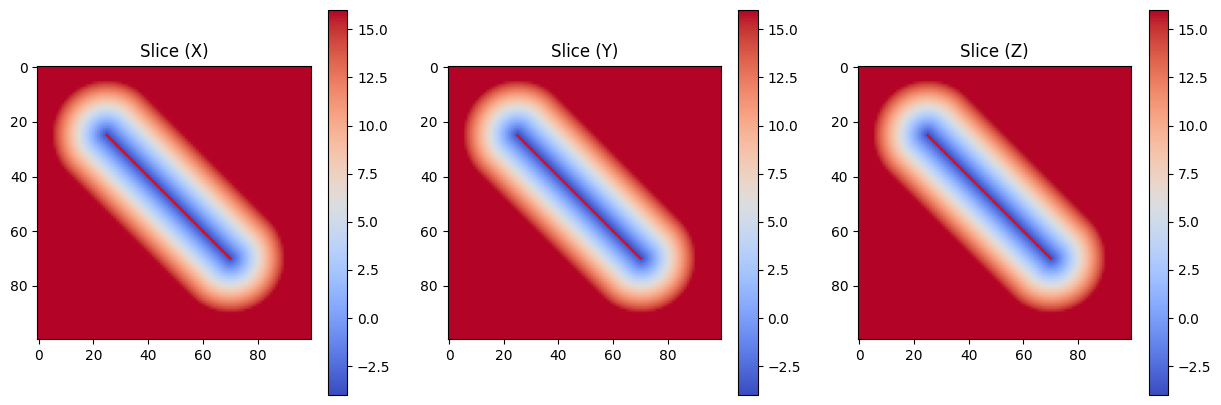

In [17]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, i, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, norms2, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf, dtype=np.float32)
tangents = np.array(tangents)

pred_perfect = s.render_distance_map((100,100,100))
 
show_slices(np.array(pred_perfect), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]

In [19]:
pred_initial2[:,:,33:34,:,:] = 16.0
pss = pred_initial2[0][0]

In [20]:
pss.shape

torch.Size([100, 100, 100])

C:\Users\serta\AppData\Local\Temp\ipykernel_26972\2399199909.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pss), g)


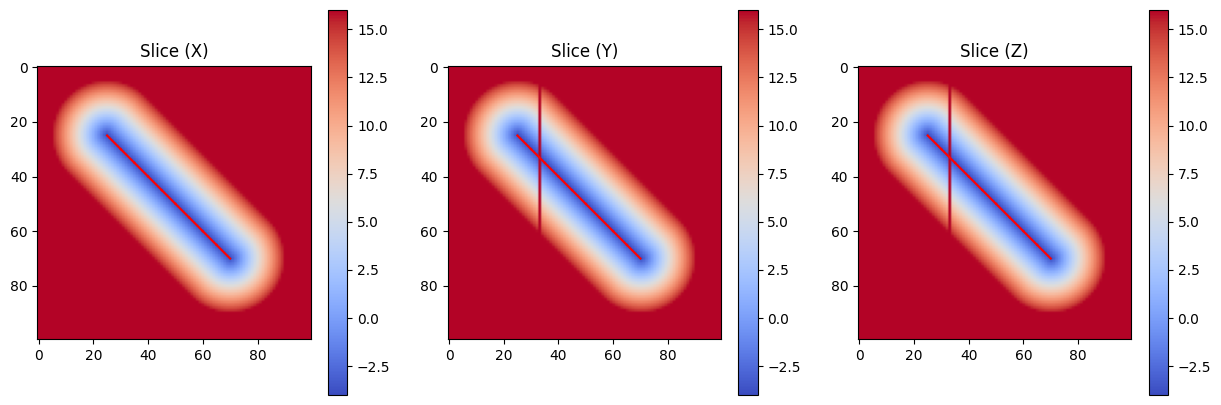

In [21]:
show_slices(np.array(pss), g)

C:\Users\serta\AppData\Local\Temp\ipykernel_33816\629028483.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  normals = np.array(norms_perf, dtype=np.float32)
C:\Users\serta\AppData\Local\Temp\ipykernel_33816\629028483.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  tangents = np.array(tangents)
C:\Users\serta\AppData\Local\Temp\ipykernel_33816\3869635687.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or 

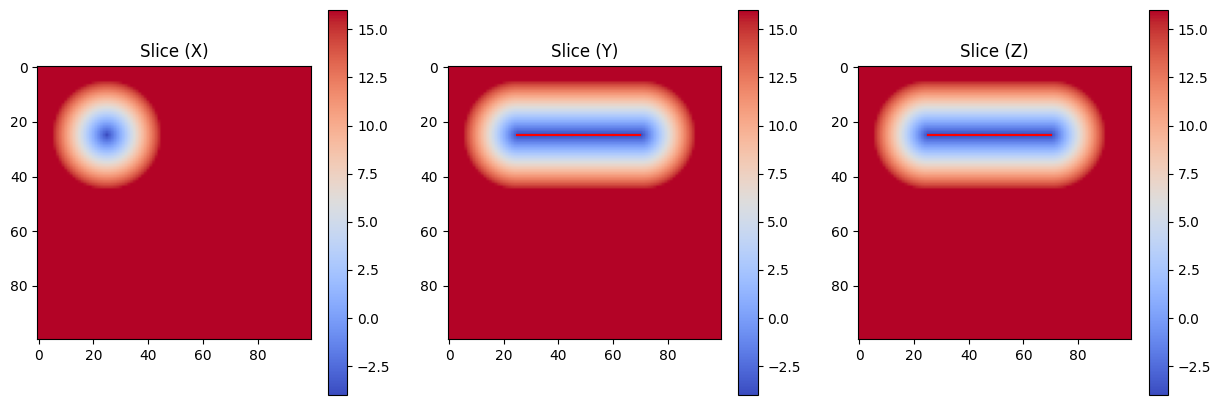

C:\Users\serta\AppData\Local\Temp\ipykernel_33816\629028483.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred_perfect), g)


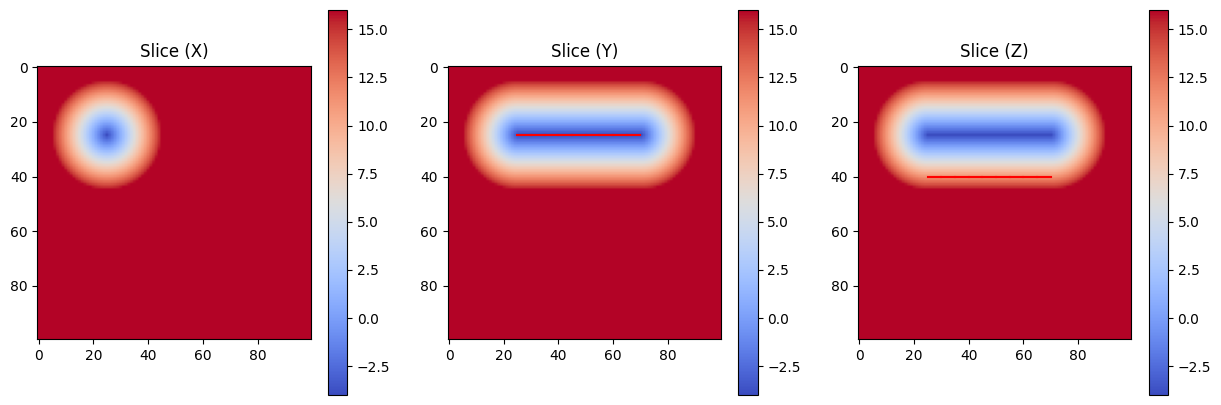

C:\Users\serta\AppData\Local\Temp\ipykernel_33816\663087910.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(dmap), l)


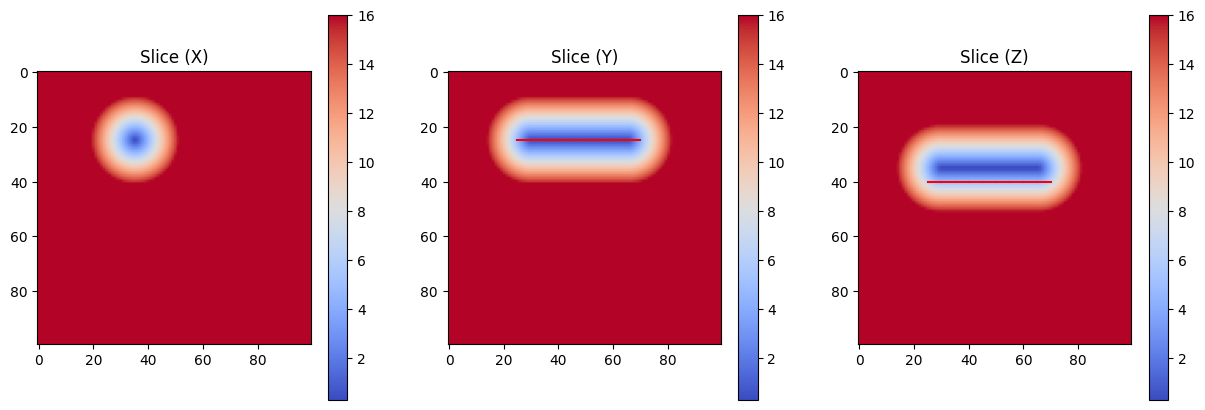

tensor(3.4324, grad_fn=<MeanBackward0>)


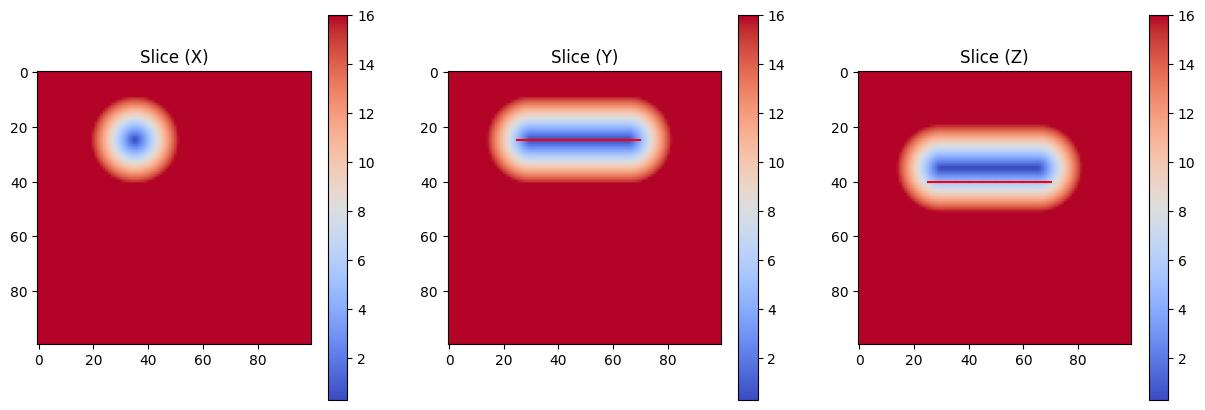

tensor(3.4292, grad_fn=<MeanBackward0>)


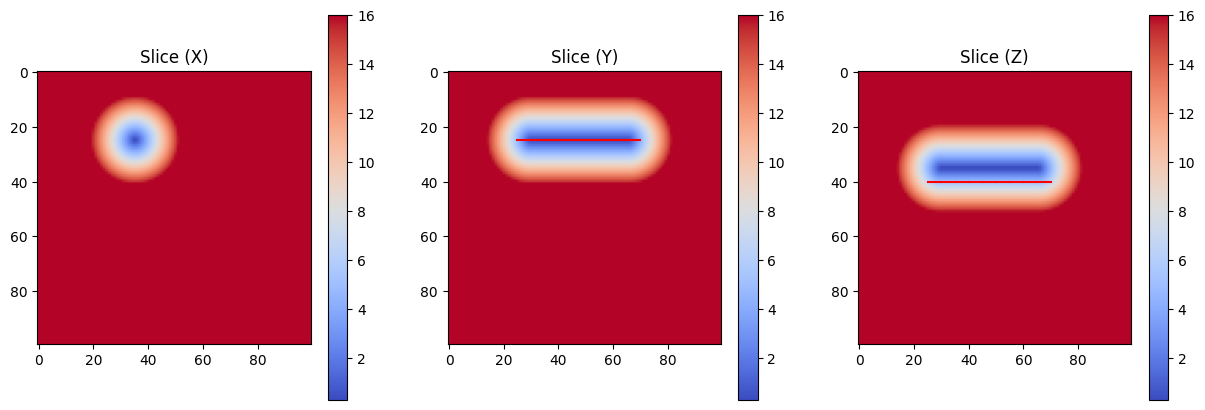

tensor(3.4259, grad_fn=<MeanBackward0>)


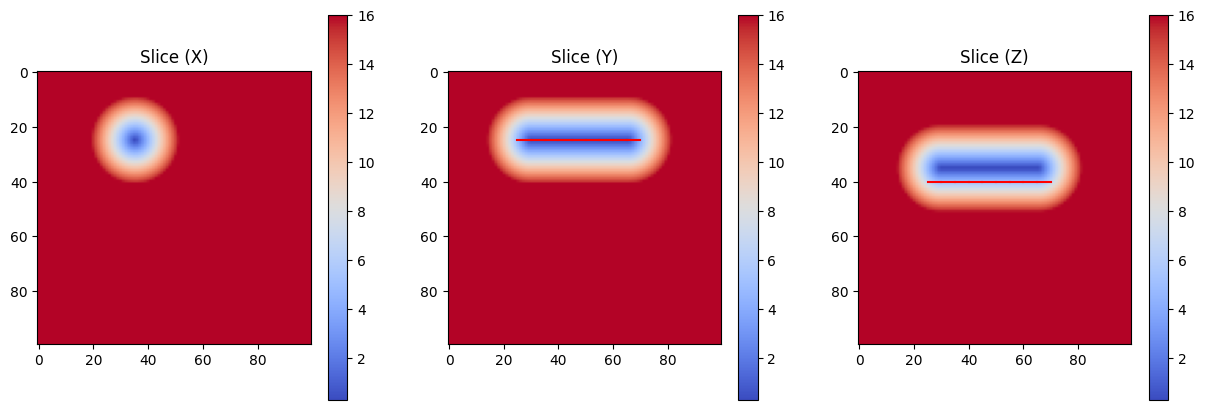

tensor(3.4226, grad_fn=<MeanBackward0>)


C:\Users\serta\AppData\Local\Temp\ipykernel_33816\629028483.py:72: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(pred2[0][0].detach()), g)


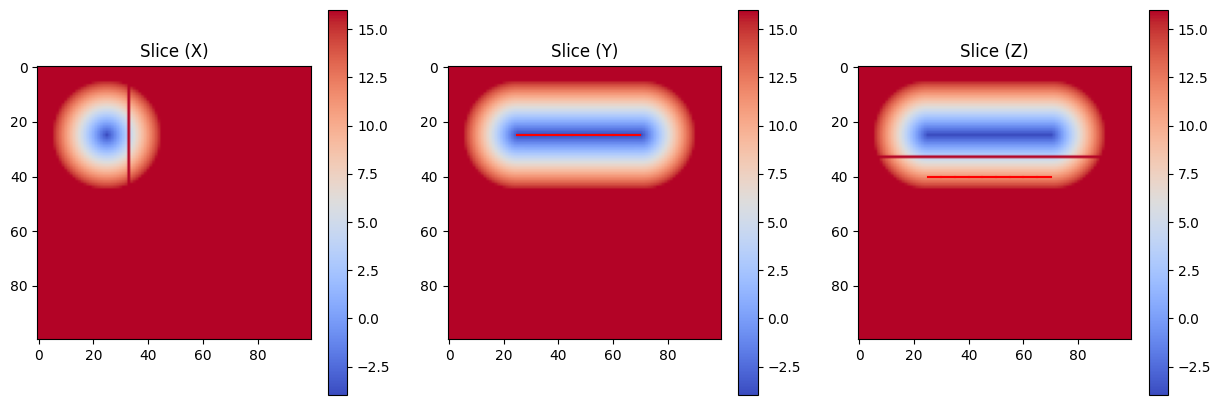

C:\Users\serta\AppData\Local\Temp\ipykernel_33816\629028483.py:81: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(final_pred[0][0]), loss.snake.getGraph())


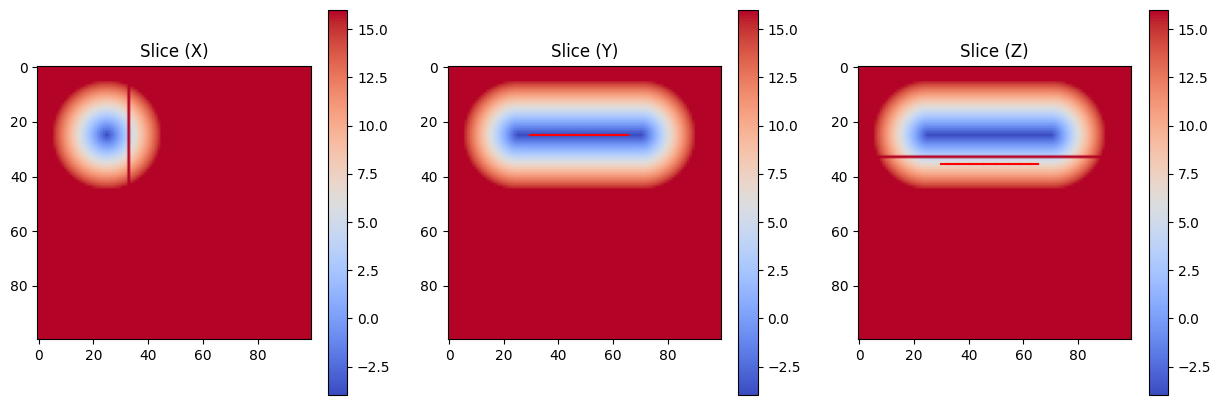

In [18]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
#widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 25, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.1
beta = 0.1
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, norms2, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf, dtype=np.float32)
tangents = np.array(tangents)

pred_perfect = s.render_distance_map((100,100,100))
 
show_slices(np.array(pred_perfect), g)

del s
pred_initial=pred_perfect.clone()[None,None]
pred_initial2=pred_perfect.clone()[None,None]
pred_initial2[:,:,:,33:34,:] = 16.0

pred=pred_initial.clone()
pred.requires_grad_(True)
pred2=pred_initial2.clone()
pred2.requires_grad_(True)

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,15,0]) 

show_slices(np.array(pred_perfect), g)

fltrstdev=1.0

opt = optim.SGD([pred2], lr=5.0, momentum=0.0)

extgradfac=1.0
nsteps=50

loss=SnakeFastLoss(stepsz,alpha,beta,fltrstdev,ndims,nsteps,
                                crop,16,4,extgradfac)

for i in range(200):
    opt.zero_grad()
    #l=loss.forward(th.stack((pred,pred2,pred3),axis=0),[g])
    l = loss.forward(pred2, [g], i)
    # this calculates the backward for the loss to change pred2
    if i % 50 == 0:
        print(l)
    l.backward()
    # optimization is done on pred2
    opt.step()

show_slices(np.array(pred2[0][0].detach()), g)
""" show_slices(np.array(pred2[0][0].detach()), g)
show_slices(np.array(th.abs(pred2-pred_initial2)[0][0].detach()),g) """

# we get the loss snakes graph
# normal original snake isn't changed
final_pred=pred2.detach()
#show_slices(np.array(pred_initial[0][0]),loss.snake.getGraph())

show_slices(np.array(final_pred[0][0]), loss.snake.getGraph())

In [10]:
loss.snake.get_w()

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3833761391.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tangents_tensor = torch.tensor(tangents, dtype=torch.float32, device=device)
C:\Users\serta\AppData\Local\Temp\ipykernel_5028\3954249983.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  show_slices(np.array(ddd), g)


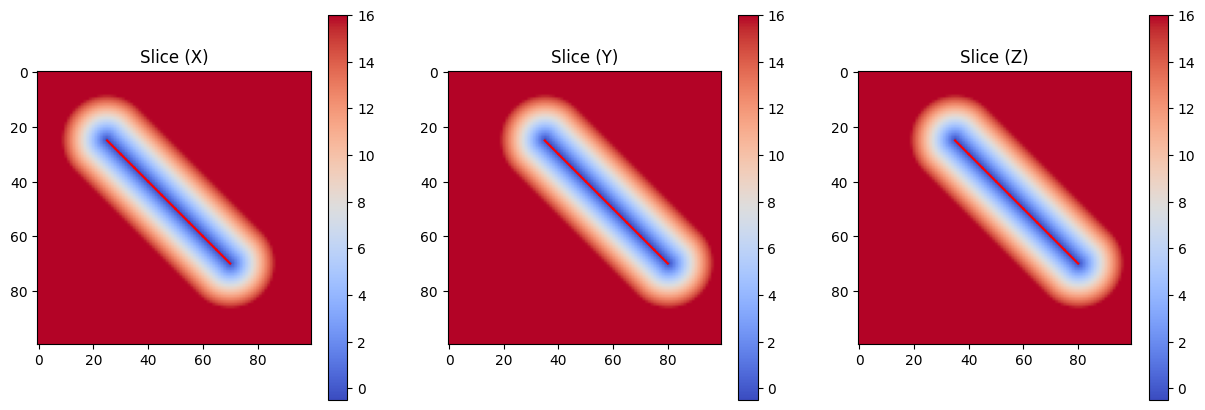

In [15]:
sa = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=3)
ddd = sa.render_distance_map((100,100,100))
show_slices(np.array(ddd), g)